In [1]:
import scanpy as sc
import pandas as pd

In [2]:
ad = sc.read_h5ad('/Volumes/Castelo_Branco/christoffer/human_ms_xenium/data/lerma_martin/spatial/merged_lerma_martin.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
ad.obs_names_make_unique()

In [4]:
human_genes = [
    "HIF1A","NFE2L2","AKT1","PIK3CD","HMOX1","TXNIP",
    "SLC16A1","SLC16A3","LDHA","LDHB","MFN1","MFN2",
    "OPA1","PKM","SIRT2","PPARGC1A", 
]

In [5]:
# Library-size normalize to 1e4 counts per cell
sc.pp.normalize_total(ad, target_sum=1e4)

# Log-transform
sc.pp.log1p(ad)

# Scale (zero-mean, unit-variance); clip to stabilize
#sc.pp.scale(ad, max_value=10)

In [6]:
region_dict = {
    "GM": "Gray matter",
    "WM": "White matter",
    "PPWM": "Periplaque white matter",
    "LR": "Lesion rim",
    "LC": "Lesion core",
    "EP": "Ependyma",
    "Ependym": "Ependyma",
    'Claustrum':'Claustrum',
    "VI": "Vascular infiltrating"
}

In [7]:
ad.obs['areas_re'] = ad.obs['areas'].map(region_dict)

In [8]:
ad[ad.obs['areas_re'].isna()].obs.areas.unique()

[], Categories (0, object): []

In [25]:
hypoxia_gene_dict = {
    "Core regulators": [
        "HIF1A", "EPAS1", "ARNT"
    ],
    "Canonical targets": [
        "VEGFA", "ADM", "BNIP3", "BNIP3L", "CA9"
    ],
    "Glycolysis shift": [
        "LDHA", "SLC2A1", "SLC2A3", "ENO1", "PGK1", "HK2"
    ],
    "Matrix / remodeling": [
        "P4HA1", "P4HA2"
    ],
    "Oxidative stress coupling": [
        "NFE2L2", "HMOX1", "SLC16A3"
    ]
}

In [15]:
ad.obs['areas_condition'] = ad.obs['areas_re'].astype(str) + '_' +ad.obs['condition'].astype(str) 

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


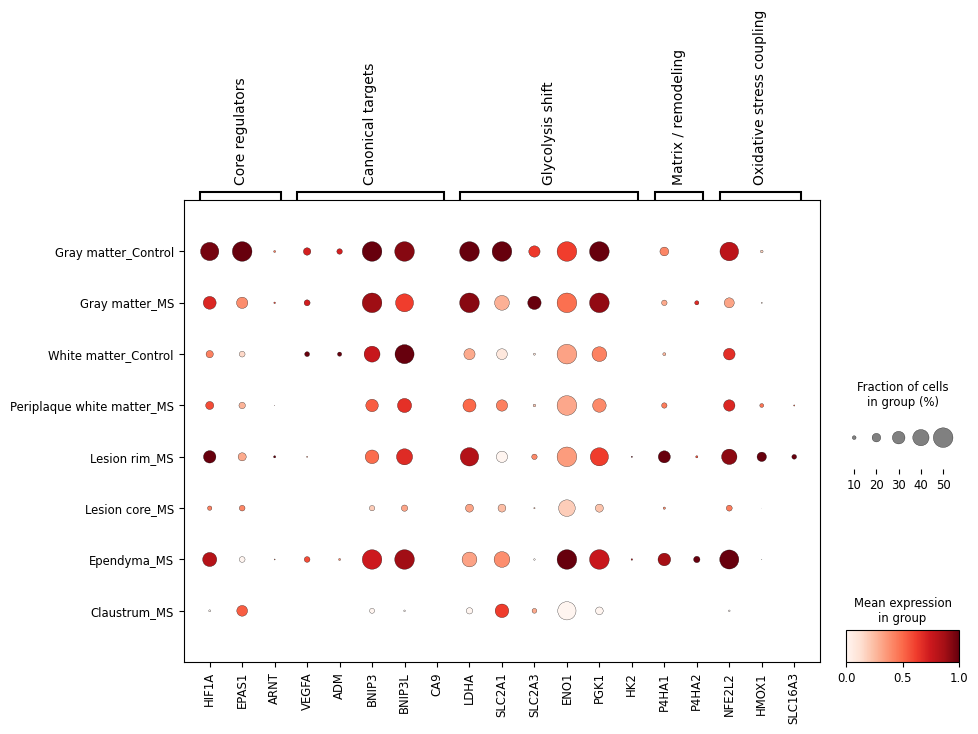

In [26]:
categories_order = [
    "Gray matter_Control",
        "Gray matter_MS",

    "White matter_Control",
    "Periplaque white matter_MS",
    "Lesion rim_MS",
    "Lesion core_MS",
    "Ependyma_MS",
    'Claustrum_MS'
]

sc.pl.dotplot(
    ad,
    var_names=hypoxia_gene_dict,
    groupby="areas_condition",  # or whatever column you used
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
    categories_order=categories_order,
    figsize=(10, 6)
)

In [37]:
hypoxia_gene_dict = hypoxia_gene_dict = {
    "Core regulators": [
        "HIF1A", "EPAS1", "ARNT"
    ],
    "Canonical targets": [
        "VEGFA", "EPO", "ADM", "BNIP3", "BNIP3L", "CA9"
    ],
    "Glycolysis shift": [
        "LDHA", "SLC2A1", "SLC2A3", "ENO1", "PGK1", "HK2"
    ],
    "Matrix / remodeling": [
        "P4HA1", "P4HA2"
    ],
    "Oxidative stress coupling": [
        "NFE2L2", "HMOX1", "SLC16A3"
    ]
}

In [39]:
genes_of_interest

['HIF1A',
 'EPAS1',
 'ARNT',
 'VEGFA',
 'ADM',
 'BNIP3',
 'BNIP3L',
 'CA9',
 'LDHA',
 'SLC2A1',
 'SLC2A3',
 'ENO1',
 'PGK1',
 'HK2',
 'P4HA1',
 'P4HA2',
 'NFE2L2',
 'HMOX1',
 'SLC16A3']

In [38]:
import numpy as np
import pandas as pd

# flatten bioenergetic gene list
genes_of_interest = [g for lst in hypoxia_gene_dict.values() for g in lst if g in ad.var_names]

# make sure you have a combined group column (like in your dotplot)
group_col = "areas_condition"  # adapt if different

# compute mean expression per group
group_means = pd.DataFrame(
    ad[:, genes_of_interest].to_df().groupby(ad.obs[group_col]).mean()
)

# comparisons
comparisons = [
    ("Gray matter_MS", "Gray matter_Control"),
    ("Periplaque white matter_MS", "White matter_Control"),
    ("Lesion rim_MS", "White matter_Control"),
    ("Lesion core_MS", "White matter_Control"),
]

# compute log2FC
results = {}
for case, ref in comparisons:
    if case in group_means.index and ref in group_means.index:
        log2fc = np.log2((group_means.loc[case] + 1e-9) / (group_means.loc[ref] + 1e-9))
        results[f"{case}_vs_{ref}"] = log2fc

# combine into dataframe
log2fc_df = pd.DataFrame(results)
log2fc_df.head()

,Gray matter_MS_vs_Gray matter_Control,Periplaque white matter_MS_vs_White matter_Control,Lesion rim_MS_vs_White matter_Control,Lesion core_MS_vs_White matter_Control
HIF1A,-0.345287,0.271573,0.824257,-0.005646
EPAS1,-0.872385,0.326381,0.396102,0.617816
ARNT,0.194610,0.351746,0.629128,0.117143
VEGFA,0.014584,-1.463004,-1.108412,-1.350491
ADM,-1.348241,-1.726364,-1.284795,-1.390737


In [28]:
import numpy as np
import pandas as pd
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

def compute_log2fc_with_stats(adata, group_col, genes, comparisons):
    results = []
    for case, ref in comparisons:
        case_mask = adata.obs[group_col] == case
        ref_mask  = adata.obs[group_col] == ref
        
        if case_mask.sum() == 0 or ref_mask.sum() == 0:
            print(f"Skipping {case} vs {ref} (no cells)")
            continue
        
        for g in genes:
            case_vals = adata[case_mask, g].X.toarray().ravel()
            ref_vals  = adata[ref_mask, g].X.toarray().ravel()
            
            log2fc = np.log2((case_vals.mean()+1e-9) / (ref_vals.mean()+1e-9))
            stat, pval = ranksums(case_vals, ref_vals)
            
            results.append({
                "comparison": f"{case}_vs_{ref}",
                "gene": g,
                "log2fc": log2fc,
                "pval": pval
            })
    
    df = pd.DataFrame(results)
    # FDR correction per comparison
    df["fdr"] = np.nan
    for comp in df["comparison"].unique():
        mask = df["comparison"] == comp
        df.loc[mask, "fdr"] = multipletests(df.loc[mask, "pval"], method="fdr_bh")[1]
    
    return df

In [43]:
# ============================
# Log2FC + stats + FDR + plots
# ============================

import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Helpers
# ----------------------------
def _to_1d(x):
    """Make a 1D numpy array from dense/sparse vectors."""
    if sp.issparse(x):
        x = x.A  # toarray()
    x = np.asarray(x)
    x = x.reshape(-1)
    return x

def _mean_expr(adata, mask, gene):
    """Mean expression for a mask & gene (safe for sparse)."""
    Xg = adata[mask, gene].X
    v = _to_1d(Xg)
    if v.size == 0:
        return np.nan
    return float(v.mean())

def _values(adata, mask, gene):
    """Values vector for a mask & gene (safe for sparse)."""
    Xg = adata[mask, gene].X
    return _to_1d(Xg)

# ----------------------------
# Core: compute log2FC + stats
# ----------------------------
def compute_log2fc_with_stats(
    adata,
    group_col,
    genes,
    comparisons,
    min_cells=5,
    test="wilcoxon",  # reserved for future choices
    eps=1e-9
):
    """
    comparisons: list of (case_group, control_group) tuples
    Returns long DataFrame with columns:
      comparison, gene, log2fc, pval, fdr, n_case, n_ctrl
    FDR is computed *within each comparison* across genes.
    """
    rows = []
    for case, ctrl in comparisons:
        case_mask = adata.obs[group_col].values == case
        ctrl_mask = adata.obs[group_col].values == ctrl

        n_case = int(case_mask.sum())
        n_ctrl = int(ctrl_mask.sum())
        if n_case < min_cells or n_ctrl < min_cells:
            print(f"[compute] Skip {case} vs {ctrl} (cells case={n_case}, ctrl={n_ctrl})")
            continue

        for g in genes:
            # means for log2FC
            m_case = _mean_expr(adata, case_mask, g)
            m_ctrl = _mean_expr(adata, ctrl_mask, g)
            log2fc = np.log2((m_case + eps) / (m_ctrl + eps))

            # stats
            v_case = _values(adata, case_mask, g)
            v_ctrl = _values(adata, ctrl_mask, g)
            if v_case.size < min_cells or v_ctrl.size < min_cells:
                pval = np.nan
            else:
                stat, pval = ranksums(v_case, v_ctrl)

            rows.append({
                "comparison": f"{case}_vs_{ctrl}",
                "gene": g,
                "log2fc": log2fc,
                "pval": pval,
                "n_case": n_case,
                "n_ctrl": n_ctrl
            })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # FDR per comparison
    df["fdr"] = np.nan
    for comp in df["comparison"].unique():
        m = df["comparison"].eq(comp) & df["pval"].notna()
        if m.sum() > 0:
            df.loc[m, "fdr"] = multipletests(df.loc[m, "pval"], method="fdr_bh")[1]
    return df

# ----------------------------
# Plotting
# ----------------------------
def _star(p):
    if pd.isna(p): return ""
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

from tqdm import tqdm

def compute_log2fc_with_stats(
    adata,
    group_col,
    genes,
    comparisons,
    min_cells=5,
    test="wilcoxon",
    eps=1e-9
):
    """
    comparisons: list of (case_group, control_group) tuples
    Returns long DataFrame with columns:
      comparison, gene, log2fc, pval, fdr, n_case, n_ctrl
    FDR is computed *within each comparison* across genes.
    """
    rows = []
    for case, ctrl in comparisons:
        case_mask = adata.obs[group_col].values == case
        ctrl_mask = adata.obs[group_col].values == ctrl

        n_case = int(case_mask.sum())
        n_ctrl = int(ctrl_mask.sum())
        if n_case < min_cells or n_ctrl < min_cells:
            print(f"[compute] Skip {case} vs {ctrl} (cells case={n_case}, ctrl={n_ctrl})")
            continue

        # tqdm here to monitor gene-level processing
        for g in tqdm(genes, desc=f"{case} vs {ctrl}", unit="gene"):
            # means for log2FC
            m_case = _mean_expr(adata, case_mask, g)
            m_ctrl = _mean_expr(adata, ctrl_mask, g)
            log2fc = np.log2((m_case + eps) / (m_ctrl + eps))

            # stats
            v_case = _values(adata, case_mask, g)
            v_ctrl = _values(adata, ctrl_mask, g)
            if v_case.size < min_cells or v_ctrl.size < min_cells:
                pval = np.nan
            else:
                stat, pval = ranksums(v_case, v_ctrl)

            rows.append({
                "comparison": f"{case}_vs_{ctrl}",
                "gene": g,
                "log2fc": log2fc,
                "pval": pval,
                "n_case": n_case,
                "n_ctrl": n_ctrl
            })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # FDR per comparison
    df["fdr"] = np.nan
    for comp in df["comparison"].unique():
        m = df["comparison"].eq(comp) & df["pval"].notna()
        if m.sum() > 0:
            df.loc[m, "fdr"] = multipletests(df.loc[m, "pval"], method="fdr_bh")[1]
    return df

# ============================
# Example usage
# ============================
# Assumptions:
#   - `ad` (or `adata`) is your AnnData
#   - ad.obs has a categorical column, e.g. "niche_condition"
#   - you have a list of genes present in ad.var_names

# 1) pick genes
# (example: your bioenergetic panel)
bioenergetic_groups = {
    "Core regulators": [
        "HIF1A", "EPAS1", "ARNT"
    ],
    "Canonical targets": [
        "VEGFA", "EPO", "ADM", "BNIP3", "BNIP3L"
    ],
    "Glycolysis shift": [
        "LDHA", "SLC2A1", "SLC2A3", "ENO1", "PGK1", "HK2"
    ],
    "Matrix / remodeling": [
        "P4HA1", "P4HA2"
    ],
    "Oxidative stress coupling": [
        "NFE2L2", "HMOX1", "SLC16A3"
    ]
}
genes_of_interest = [g for lst in bioenergetic_groups.values() for g in lst]
# keep only genes present in the dataset
genes_of_interest = [g for g in genes_of_interest if g in ad.var_names]

# 2) define comparisons (examples)
comparisons = [
    ("Gray matter_MS", "Gray matter_Control"),
        ("Periplaque white matter_MS", "White matter_Control"),

    ("Lesion rim_MS", "White matter_Control"),
        ("Lesion core_MS", "White matter_Control"),

    # add more as needed
]

# 3) compute stats
df_stats = compute_log2fc_with_stats(
    adata=ad,
    group_col="areas_condition",
    genes=genes_of_interest,
    comparisons=comparisons,
    min_cells=10,        # raise if you want stricter cell-count floor
    eps=1e-9
)


Gray matter_MS vs Gray matter_Control: 100%|██| 18/18 [00:00<00:00, 22.56gene/s]
Periplaque white matter_MS vs White matter_Control: 100%|█| 18/18 [00:02<00:00, 
Lesion core_MS vs White matter_Control: 100%|█| 18/18 [00:02<00:00,  6.46gene/s]


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def _star(p):
    if pd.isna(p): return ""
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

def plot_log2fc_bars_with_stats(
    df_stats,
    top_n=20,
    ncols=2,
    width=6,
    height_per_panel=5,
    cmap_pos="#C0392B",   # up color (red)
    cmap_neg="#2471A3",   # down color (blue)
    title_prefix="Log₂FC"
):
    """
    One horizontal bar panel per comparison.
    Bars are ordered by log2fc (so up = top, down = bottom).
    Annotates significance stars from FDR.
    """
    if df_stats.empty:
        print("[plot] Nothing to plot (empty df).")
        return

    comps = list(df_stats["comparison"].unique())
    n = len(comps)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(ncols*width, nrows*height_per_panel),
        squeeze=False
    )
    axes = axes.flatten()

    for ax, comp in zip(axes, comps):
        sub = df_stats[df_stats["comparison"] == comp].copy()
        # order by log2fc (so negatives go at bottom)
        sub = sub.sort_values("log2fc", ascending=False).head(top_n)

        # color by sign
        colors = np.where(sub["log2fc"] >= 0, cmap_pos, cmap_neg)

        ax.barh(sub["gene"], sub["log2fc"], color=colors, alpha=0.9, edgecolor="none")
        ax.axvline(0, color="k", lw=0.8, ls="--")

        # annotate stars
        for y, (l2fc, fdr) in enumerate(zip(sub["log2fc"], sub["fdr"])):
            s = _star(fdr)
            if s:
                x = l2fc + (0.02 if l2fc >= 0 else -0.02)
                ha = "left" if l2fc >= 0 else "right"
                ax.text(x, y, s, va="center", ha=ha, fontsize=10)

        ax.set_title(f"{title_prefix}: {comp}")
        ax.set_xlabel("log₂FC (case / control)")
        ax.set_ylabel("Gene")

    # turn off unused axes
    for ax in axes[len(comps):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

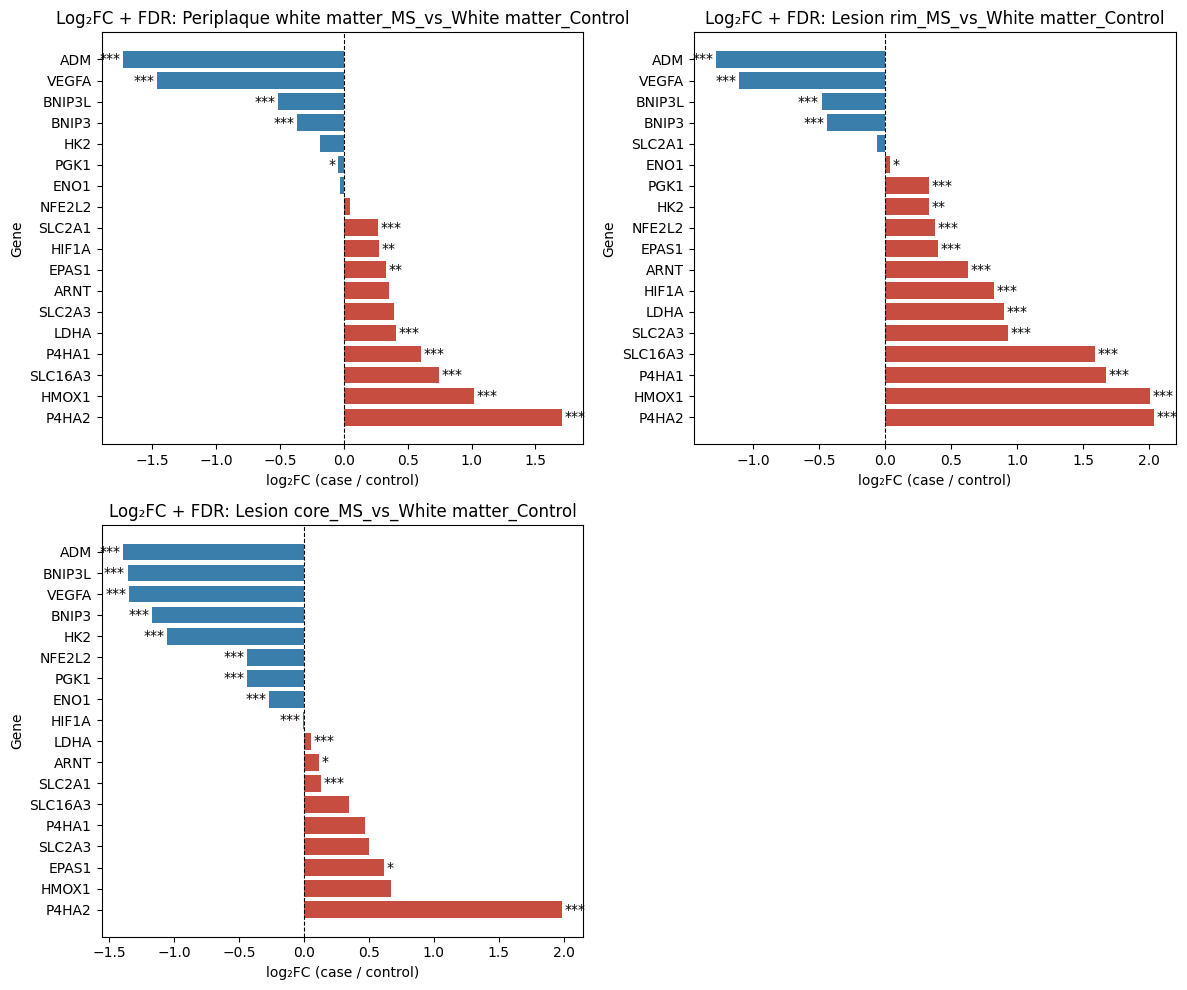

In [45]:
# 4) plot
plot_log2fc_bars_with_stats(
    df_stats[df_stats.comparison.str.contains('White')],
    top_n=20,
    ncols=2,
    title_prefix="Log₂FC + FDR"
)

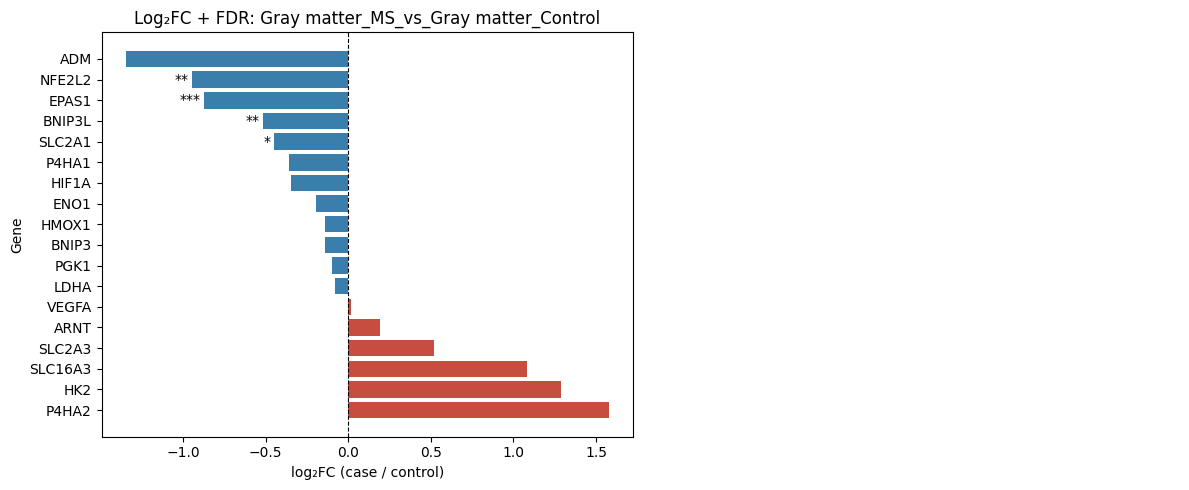

In [46]:
# 4) plot
plot_log2fc_bars_with_stats(
    df_stats[df_stats.comparison.str.contains('Gray')],
    top_n=20,
    ncols=2,
    title_prefix="Log₂FC + FDR"
)

In [21]:
df_stats[df_stats.gene == 'SLC16A3']

,comparison,gene,log2fc,pval,n_case,n_ctrl,fdr
7,Gray matter_MS_vs_Gray matter_Control,SLC16A3,1.084866,8.827346e-01,6235,98,8.827346e-01
22,Periplaque white matter_MS_vs_White matter_Con...,SLC16A3,0.744619,5.042675e-04,10977,23982,1.080573e-03
37,Lesion rim_MS_vs_White matter_Control,SLC16A3,1.589384,1.248350e-22,6512,23982,3.745049e-22
52,Lesion core_MS_vs_White matter_Control,SLC16A3,0.346281,2.997494e-01,19446,23982,3.211601e-01


In [22]:
spatial = np.array(ad.obs[['array_row','array_col']].astype(int))
ad.obsm['spatial'] = spatial

In [ ]:
for run in ad.obs['sample_id'].unique():
    print(run)
    ad_int = ad[ad.obs['sample_id'] == run]
    with plt.rc_context({'figure.figsize': (5, 10)}):
        sc.pl.spatial(ad_int, spot_size=1.25, color = ['areas','LDHA','PIK3CD','IGHG4'],)
    plt.show()
    

In [25]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from joblib import Parallel, delayed

def compute_log2fc_fast(
    adata,
    group_col,
    genes,
    comparisons,
    min_cells=10,
    top_k_for_stats=500,      # test only top-K by |log2FC| per comparison
    expr_min_frac=0.05,       # keep genes expressed in ≥5% cells in case or ctrl
    eps=1e-9,
    n_jobs=1,                 # >1 to parallelize stats
    show_progress=True
):
    results = []
    iterator = tqdm(comparisons, desc="Comparisons", disable=not show_progress)

    for case, ctrl in iterator:
        case_mask = (adata.obs[group_col].values == case)
        ctrl_mask = (adata.obs[group_col].values == ctrl)
        n_case, n_ctrl = int(case_mask.sum()), int(ctrl_mask.sum())
        if n_case < min_cells or n_ctrl < min_cells:
            continue

        # Submatrix once, vectorized means
        X_case = adata[case_mask, genes].X
        X_ctrl = adata[ctrl_mask, genes].X
        if sp.issparse(X_case): X_case = X_case.tocsr()
        if sp.issparse(X_ctrl): X_ctrl = X_ctrl.tocsr()

        # Expression fraction filter
        frac_case = (X_case > 0).mean(axis=0).A1 if sp.issparse(X_case) else (X_case > 0).mean(axis=0)
        frac_ctrl = (X_ctrl > 0).mean(axis=0).A1 if sp.issparse(X_ctrl) else (X_ctrl > 0).mean(axis=0)
        keep = (frac_case >= expr_min_frac) | (frac_ctrl >= expr_min_frac)
        if keep.sum() == 0:
            continue
        genes_kept = np.array(genes)[keep]

        m_case = np.asarray(X_case[:, keep].mean(axis=0)).ravel()
        m_ctrl = np.asarray(X_ctrl[:, keep].mean(axis=0)).ravel()
        log2fc = np.log2((m_case + eps) / (m_ctrl + eps))

        # Rank by |log2FC| and choose top-K for stats
        order = np.argsort(-np.abs(log2fc))
        sel = order[:min(top_k_for_stats, len(order))]

        # Prepare vectors for stats
        def wilcoxon_one(idx):
            vc = X_case[:, sel[idx]].toarray().ravel() if sp.issparse(X_case) else X_case[:, sel[idx]].ravel()
            vr = X_ctrl[:, sel[idx]].toarray().ravel() if sp.issparse(X_ctrl) else X_ctrl[:, sel[idx]].ravel()
            try:
                _, p = ranksums(vc, vr)
            except Exception:
                p = np.nan
            return p

        if n_jobs == 1:
            pvals = [wilcoxon_one(i) for i in range(len(sel))]
        else:
            pvals = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(wilcoxon_one)(i) for i in range(len(sel)))

        # FDR on tested genes
        pvals = np.array(pvals, dtype=float)
        fdr = np.full_like(log2fc, np.nan, dtype=float)
        if np.isfinite(pvals).any():
            fdr_sel = multipletests(pvals[np.isfinite(pvals)], method="fdr_bh")[1]
            fdr_idx = np.where(np.isfinite(pvals))[0]
            fdr[sel[fdr_idx]] = fdr_sel

        # Collect rows
        for g, l2, f in zip(genes_kept, log2fc, fdr):
            results.append({
                "comparison": f"{case}_vs_{ctrl}",
                "gene": g,
                "log2fc": float(l2),
                "fdr": float(f),
                "n_case": n_case,
                "n_ctrl": n_ctrl
            })

    return pd.DataFrame(results)

In [27]:
df_stats = compute_log2fc_fast(
    adata=ad,
    group_col="areas_condition",
    genes=list(ad.var_names),
    comparisons=[
       ("Gray matter_MS", "Gray matter_Control"),
        ("Periplaque white matter_MS", "White matter_Control"),
    ("Lesion rim_MS", "White matter_Control"),
        ("Lesion core_MS", "White matter_Control"),
    ],
    show_progress=True
)

Comparisons: 100%|████████████████████████████████| 4/4 [00:35<00:00,  8.97s/it]


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_genes(
    df_stats,
    top_n=20,
    fdr_thresh=0.05,
    title_prefix="Top genes per comparison",
    cmap_pos="#C0392B",   # red
    cmap_neg="#2471A3"    # blue
):
    """
    Plots bar charts of the top_n most strongly DE genes per comparison.
    """
    if df_stats.empty:
        print("⚠️ No stats to plot.")
        return

    # filter significant genes
    sig = df_stats[df_stats["fdr"] < fdr_thresh].copy()
    if sig.empty:
        print("⚠️ No significant genes below FDR threshold.")
        return

    comparisons = sig["comparison"].unique()
    n = len(comparisons)

    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n), sharex=False)
    if n == 1:
        axes = [axes]

    for ax, comp in zip(axes, comparisons):
        sub = sig[sig["comparison"] == comp].copy()
        sub = sub.reindex(sub["log2fc"].abs().sort_values(ascending=False).index)
        sub = sub.head(top_n)

        colors = [cmap_pos if lfc > 0 else cmap_neg for lfc in sub["log2fc"]]
        sns.barplot(
            data=sub,
            y="gene", x="log2fc",
            palette=colors, ax=ax
        )
        ax.axvline(0, color="k", lw=0.8, ls="--")
        ax.set_title(f"{title_prefix}: {comp}")
        ax.set_xlabel("log₂FC (case / control)")
        ax.set_ylabel("Gene")

    plt.tight_layout()
    plt.show()
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top10_up_down(
    df_stats: pd.DataFrame,
    fdr_thresh: float = 0.05,
    only_significant: bool = True,
    n_up: int = 10,
    n_down: int = 10,
    title_prefix: str = "Top±10 genes per comparison",
    color_up: str = "#C0392B",   # red
    color_down: str = "#2471A3", # blue
    annotate_stars: bool = True
):
    """
    For each comparison in df_stats, plot the top n_up upregulated and
    n_down downregulated genes. Highest up on top, most downregulated at bottom.
    """
    if df_stats.empty:
        print("⚠️ df_stats is empty.")
        return

    df = df_stats.copy()
    if only_significant:
        df = df[df["fdr"] < fdr_thresh].copy()
        if df.empty:
            print(f"⚠️ No genes pass FDR < {fdr_thresh}.")
            return

    comps = df["comparison"].unique()
    n = len(comps)
    fig, axes = plt.subplots(n, 1, figsize=(9, max(4, 6*n)), sharex=False)
    if n == 1:
        axes = [axes]

    def stars(p):
        if pd.isna(p): return ""
        return "***" if p < 1e-3 else ("**" if p < 1e-2 else ("*" if p < 5e-2 else ""))

    for ax, comp in zip(axes, comps):
        sub = df[df["comparison"] == comp].copy()
        if sub.empty:
            ax.axis("off"); continue

        # top up & down
        up = sub[sub["log2fc"] > 0].sort_values("log2fc", ascending=False).head(n_up)
        dn = sub[sub["log2fc"] < 0].sort_values("log2fc", ascending=True).head(n_down)

        pick = pd.concat([up, dn], axis=0)

        if pick.empty:
            ax.text(0.5, 0.5, f"No hits for {comp}", ha="center", va="center")
            ax.axis("off"); continue

        # order: up first (largest to smallest), then down (smallest to largest)
        pick = pd.concat([
            up.sort_values("log2fc", ascending=False),
            dn.sort_values("log2fc", ascending=True)
        ], axis=0)

        # ensure y-axis order matches (highest at top)
        pick = pick.sort_values("log2fc", ascending=False)

        # colors
        colors = [color_up if v > 0 else color_down for v in pick["log2fc"]]

        sns.barplot(
            data=pick,
            y="gene", x="log2fc",
            palette=colors, ax=ax,
            order=pick["gene"]
        )
        ax.axvline(0, color="k", lw=0.8, ls="--")
        ax.set_title(f"{title_prefix}: {comp}")
        ax.set_xlabel("log₂FC (case / control)")
        ax.set_ylabel("Gene")

        # annotate stars
        if annotate_stars:
            for i, (lfc, fdr) in enumerate(zip(pick["log2fc"], pick["fdr"])):
                s = stars(fdr)
                if s:
                    x = lfc + (0.02 if lfc >= 0 else -0.02)
                    ha = "left" if lfc >= 0 else "right"
                    ax.text(x, i, s, va="center", ha=ha, fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
# 1) Define the comparisons (match the panels you showed)
comparisons2 = [
    ("Gray matter_MS", "Gray matter_Control"),
    ("Periplaque white matter_MS", "White matter_Control"),
    ("Lesion rim_MS", "White matter_Control"),
    ("Lesion core_MS", "White matter_Control"),
]

# 2) Pick the gene universe (all genes) or restrict to a panel if you prefer
genes_all = list(ad.var_names)

# 3) Compute stats (log2FC, Wilcoxon, FDR per comparison)
df_stats2 = compute_log2fc_with_stats(
    adata=ad,
    group_col="areas_condition",   # <- adjust if your group column is named differently
    genes=genes_all,
    comparisons=comparisons2,
    min_cells=10,
    eps=1e-9
)

# 4) Plot top ±15 per comparison (most upregulated at top, most downregulated at bottom)
plot_top10_up_down(
    df_stats2,
    fdr_thresh=0.05,
    only_significant=True,   # set False if you want to always show 15 + 15 even if not sig
    n_up=15,
    n_down=15,
    title_prefix="Top±15 genes per comparison",
    color_up="#C0392B",
    color_down="#2471A3",
    annotate_stars=True
)

Gray matter_MS vs Gray matter_Control:  10%| | 2199/23049 [01:24<12:55, 26.89gen

## Differential Expression Across MS Lesion Niches

### Gray matter (MS vs. Control)
- Strong upregulation of **VIP** and **ST3GAL1** → suggests altered neuronal/glial signaling and glycosylation pathways.  
- Increased **SLC36A1** (amino acid transporter) and **SEC16B** (vesicle trafficking).  
- Downregulation of neuronal/glial markers (**NEUROD1, MOBP, GJB1**) → indicates neuronal/oligodendrocyte vulnerability.  

### Periplaque white matter (MS vs. Control)
- Marked upregulation of immunoglobulin genes (**IGHG3, IGKC, IGHG1**) → B-cell/antibody activity at lesion borders.  
- Elevated **SERPINA3** (acute phase/reactive astrocyte marker).  
- Transport/metabolism genes (**SLC5A5, SLC5A3**) upregulated, suggesting osmotic/ionic stress adaptation.  
- Increased **S100A9, VSIG4** → immune infiltration and inflammation.  

### Lesion rim (MS vs. Control)
- Strong enrichment of **SIGLEC1 (CD169)** and **ST14**, highlighting activated macrophage/microglial phenotypes.  
- Increased **PLA2G7, RBM47, PDE3B** → lipid metabolism and inflammatory signaling.  
- Upregulation of **OTOA, S100A4, TLR2** → structural/stress and immune programs.  
- Reflects a highly inflammatory, immune-active niche.  

### Lesion core (MS vs. Control)
- Predominant **downregulation** of multiple transcripts (**AC093330.1, TMEM125, SNX22, MAP6D1**) → transcriptional silencing/cell loss.  
- Some genes remain elevated (**IGLC2, LMOD1**) → B-cell infiltration and cytoskeletal remodeling.  
- Overall picture: loss of homeostatic/structural programs with residual immune activation.  